In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma

# Exercice 4.3.1

Méthode de simulation rapide d'une variable géométrique. Avec `numpy`:

In [3]:
N = 5000000  # nombre de tirages
p = 0.01
G1 = np.random.geometric(p=p, size=N)  # methode native

Méthode de l'exercice:

In [4]:
lam = -np.log(1-p) # Le λ correspondant à p
U = np.random.uniform(size=N) # on tire des variables uniforme U[0,1] i.i.d
G2 = 1 + np.floor(-np.log(U) / lam) # G2 est composée de variables géométriques i.i.d

On compare les histogrammes donnés par les deux méthodes:

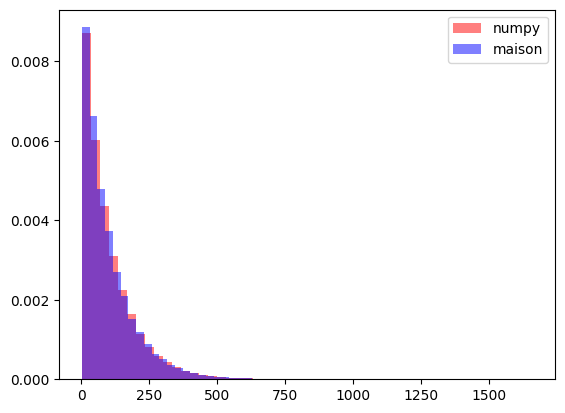

In [5]:
fig = plt.figure()
plt.hist(G1, density=True, label="numpy", bins=50, alpha=0.5, color="r")
plt.hist(G2, density=True, label="maison", bins=50, alpha=0.5, color="b")
plt.legend(loc="best")
plt.show()

# Exercice 4.3.2
On veut simuler une variable de Poisson $\mathcal P(\lambda)$. La librairie `numpy` offre une fonction pour cela.

In [6]:
N = 100000  # nombre de tirages
lam = 3.0
P1 = np.random.poisson(lam, size=N)  # methode numpy

## Méthode 1: lien avec la loi exponentielle

Il s'agit de la méthode de l'exercice 4.3.2

In [7]:
def poisson_maison(lam):
    u = -np.log(np.random.rand()) #variable exponentielle U[0,1]
    r = lam # exp(-λ)
    i = 0
    while u < r: #tant que le produit ne dépasse pas r, on itère
        u -= np.log(np.random.rand())
        i += 1
    return i # on renvoie le premier indice satisfaisant la condition

In [8]:
P2 = np.array([poisson_maison(lam) for i in range(N)]) # nos variables de Poisson i.i.d

## Méthode 2: approximation par la loi des petits nombres

On a vu dans l'exercice 2.6.5 que l'on pouvait approximer, pour $k\in\mathbb Z$, $\mathbb{P}(X=n)$ où $X \sim \mathcal{P}(\lambda)$ par $\mathbb{P}(X_m = n)$, où $X_m \sim \mathrm{Bin}(m,p_m)$, avec $m p_m\approx \lambda$.
Il est en fait facile de montrer que $X_m$ converge en loi vers $X$, par exemple si $p_m =\frac{\lambda}{m}$. Comme il est facile de simuler des variables binomiales par des sommes de variables de Bernoulli, ceci suggère une méthode (approximative) pour simuler une loi de Poisson.

In [9]:
m=2000
U=np.random.uniform(size=(N,m))
pm = lam/m
Xm = np.sum(U<=pm , axis = 1) # variables binomiales i.i.d.

Petite comparaison d'histogrammes:

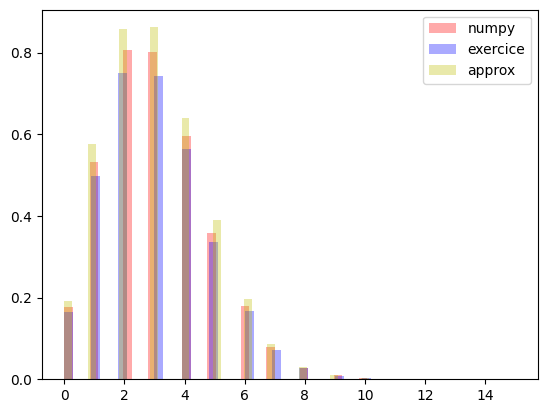

In [10]:
fig = plt.figure()
plt.hist(P1, density=True, label="numpy", bins=50, alpha=1/3, color="r")
plt.hist(P2, density=True, label="exercice", bins=50, alpha=1/3, color="b")
plt.hist(Xm,density=True,label="approx",bins=50,alpha=1/3,color="y")
plt.legend(loc="best")
plt.show()


# Exercice 4.3.3

On compare différentes méthodes pour simuler des Gaussiennes standard indépendantes. Avec `numpy`, on utilise la fonction suivante.

In [11]:
N = 100000
mu, sigma = 0.0, 1.0

G1 = np.random.normal(loc=mu, scale=sigma, size=N)  # méthode numpy de base

## Méthode 1: Box-Muller

Elle consiste à exploiter l'égalité en loi
$$(\sqrt{R}\cos \Theta ,\sqrt{R}\sin \Theta) \overset{\mathcal{L}}{=} G\sim\mathcal{N}\left(0,I_2\right),\$$
où $R\sim \mathcal{E}(1/2)$ est une variable exponentielle et $\Theta \sim \mathcal{U}[0,2\pi]$ une variable uniforme.


In [12]:
R = np.random.exponential(scale=2.0, size=N//2)  # scale= 1/lambda
T = 2*np.pi*np.random.uniform(size=N//2)
G2 = np.concatenate((np.sqrt(R)*np.cos(T), np.sqrt(R)*np.sin(T)))

## Méthode 2: Box-Muller par méthode de rejet

On utilise l'égalité en loi prouvée dans l'exercice, à savoir
$$\left(X\sqrt{\frac{-2\ln(X^2+Y^2)}{X^2+Y^2}},Y\sqrt{\frac{-2\ln(X^2+Y^2)}{X^2+Y^2}}\right)\overset{\mathcal{L}}{=} G\sim\mathcal{N}\left(0,I_2\right),$$

où le couple $(X,Y)$ est distribué uniformément sur le disque $D(0,1)$. On tire selon la loi de $(X,Y)$ par une méthode de rejet par rapport à la densité uniforme sur $[-1,1]^2$.

k empirique =  1.2711648955102457  k theorique =  1.2732395447351628


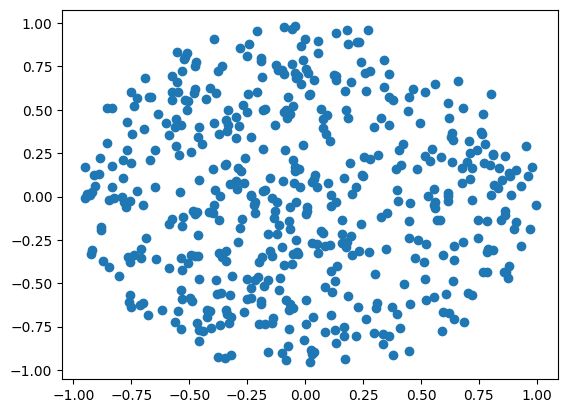

In [13]:
X = np.random.uniform(low=-1.0, high=1.0, size=N//2)
Y = np.random.uniform(low=-1.0, high=1.0, size=N//2)

# rejet
X_tmp = X[X**2+Y**2 < 1]
Y = Y[X**2+Y**2 < 1]
X = X_tmp

print("k empirique = ", (N//2)/np.size(X), " k theorique = ", 4/np.pi)

fig = plt.plot()
plt.scatter(X[:500],Y[:500])
plt.show()

On peut ensuite tirer selon la méthode proposée

In [14]:
R = X**2 + Y**2
G3 = np.concatenate((X*np.sqrt(-2*np.log(R)/R), Y*np.sqrt(-2*np.log(R)/R)))


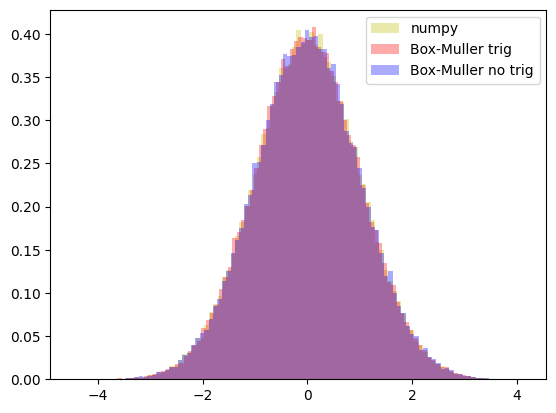

In [15]:
fig = plt.figure()
plt.hist(G1, density=True, label="numpy", alpha=1/3, color="y", bins=100)
plt.hist(G2, density=True, label="Box-Muller trig",
         alpha=1/3, color="r", bins=100)
plt.hist(G3, density=True, label="Box-Muller no trig",
         alpha=1/3, color="b", bins=100)

plt.legend(loc="best")

plt.show()

# Exercice 4.3.6

On cherche à implémenter une méthode pour simuler une loi $\Gamma(a,\theta)$.
On écrit $ a = \alpha + \lfloor a\rfloor$ avec $0\leq \alpha <1$. Cette écriture est unique.
Vérifions d'abord que 
$$ \frac1\theta\left(Y - \ln\left(\prod_{k=1}^{\lfloor a\rfloor}U_k\right)\right) \overset{\mathcal L}{=} G \sim \Gamma(a,\theta),$$
où les $U_i$ sont i.i.d uniformes sur $[0,1]$.

In [16]:
a = np.pi  # 3.14..
m = 3
alpha = a-3
theta = 0.5

Galpha = gamma(alpha)

N = 100000  # nombre de tirages
G1 = np.random.gamma(shape=a, scale=1/theta, size=N) # loi gamma avec numpy

In [17]:
G2 = np.random.gamma(shape=alpha, size=N)
U=np.random.uniform(size=(N,m))
G2-=np.sum(np.log(U),axis=1) # log du produit= somme des log
G2 /= theta

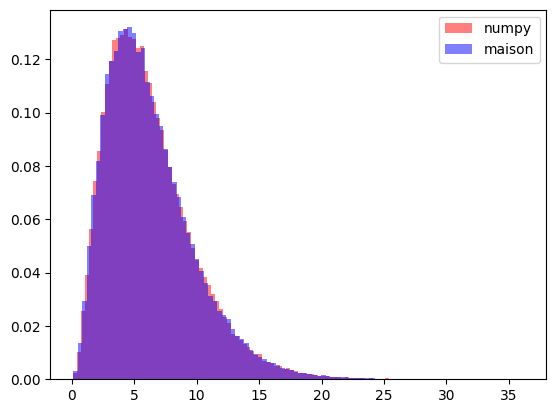

In [18]:
fig = plt.figure()
plt.hist(G1, density=True, bins=100, color="r", alpha=0.5, label="numpy")
plt.hist(G2, density=True, bins=100, color="b", alpha=0.5, label="maison")

plt.legend(loc="best")
plt.show()

Le seul problème est donc de simuler selon la loi $\Gamma(\alpha,1)$ pour $0<\alpha<1$.

## Méthode 1: rejet par rapport à une densité bien choisie

On va implémenter la méthode de rejet de la question 1.b, avec 
$$q(x)= \begin{cases} \frac{\alpha e}{\alpha+e}x^{\alpha-1} && 0< x \leq 1,\\
\frac{\alpha e}{\alpha+e} e^{-x} && x>1\end{cases}$$

/tmp/ipykernel_284746/2322074609.py:2: RuntimeWarning: divide by zero encountered in power
  px = np.exp(-x)*(x**(alpha-1))/Galpha
/tmp/ipykernel_284746/2322074609.py:4: RuntimeWarning: divide by zero encountered in power
  qx[x < 1] = x[x < 1]**(alpha-1)


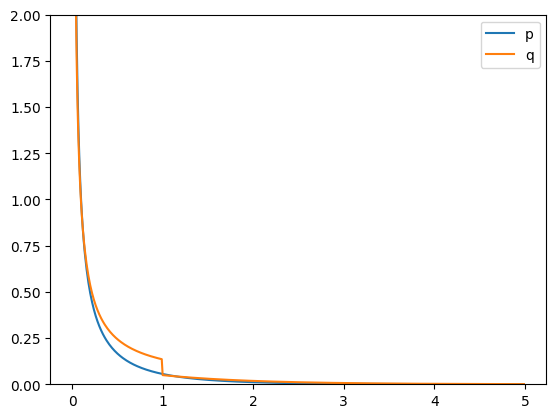

In [19]:
x = np.arange(0, 5, 0.01)
px = np.exp(-x)*(x**(alpha-1))/Galpha
qx = np.zeros_like(x)
qx[x < 1] = x[x < 1]**(alpha-1)
qx[x >= 1] = np.exp(-x[x >= 1])

qx *= (alpha*np.e)/(alpha+np.e)
fig = plt.figure()
plt.plot(x, px, label="p")



plt.plot(x, qx, label="q")
plt.legend(loc="best")
plt.ylim(0, 2)
plt.show()

On implémente à présent la méthode de rejet. Il faut d'abord échantilloner selon la densité $q$.

In [20]:
U = np.random.uniform(size=N)
Y = np.zeros_like(U)
c = (np.e)/(np.e + alpha)
Y[U <= c] = ((alpha+np.e)*U[U <= c]/np.e)**(1/alpha)
Y[U > c] = -np.log(((alpha+np.e)*U[U > c]/np.e - 1)/alpha)

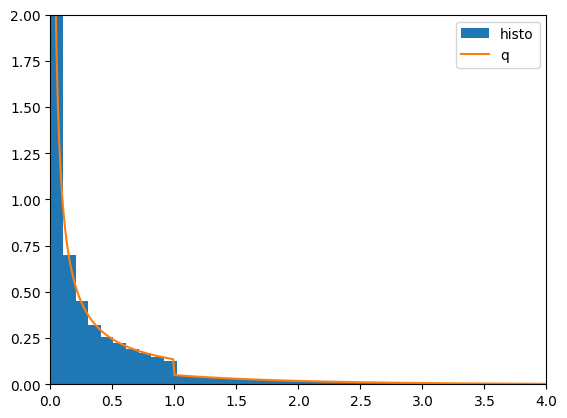

In [21]:
fig = plt.plot()
plt.hist(Y, density=True, label="histo", bins=100)
plt.plot(x, qx, label="q")
plt.legend(loc="best")
plt.ylim(0, 2)
plt.xlim(0,4)
plt.show()

Pour implémenter la méthode de rejet, on se donne une famille *i.i.d* $(V_i)_{i\geq 1}$ de variables uniformes sur $[0,1]$ et une autre $(Y_i)_{i\geq 1}$ de densité $q$. Le théorème sur la méthode de rejet implique que la famille (aléatoire)
$$\left\{Y_i(\omega): kq(Y_i)V_i(\omega)\leq p(Y_i)(\omega)\right\}$$
est composée de variables *i.i.d* de densité $p$.

Pour selectionner les indices vérifiant la condition de non-rejet, on peut utiliser la syntaxe d'indexation booléenne offerte par `numpy`.

In [22]:
V = np.random.uniform(size=N)
# calcul des q(Y_i)
q_Y = np.zeros_like(Y)
q_Y[Y <= 1] = Y[Y <= 1]**(alpha-1)
q_Y[Y > 1] = np.exp(-Y[Y>1])

q_Y *= (alpha*np.e)/(alpha+np.e)
#calcul des p(Y_i)
p_Y = Y**(alpha-1)*np.exp(-Y)/Galpha

k = (alpha+np.e)/(alpha*np.e*Galpha) # notre constante k
G3 = Y[k*q_Y*V <= p_Y] # étape de rejet

print("k theorique = ", k," k empirique = ",N/G3.size)

k theorique =  1.1241838199745562  k empirique =  1.123317831547258


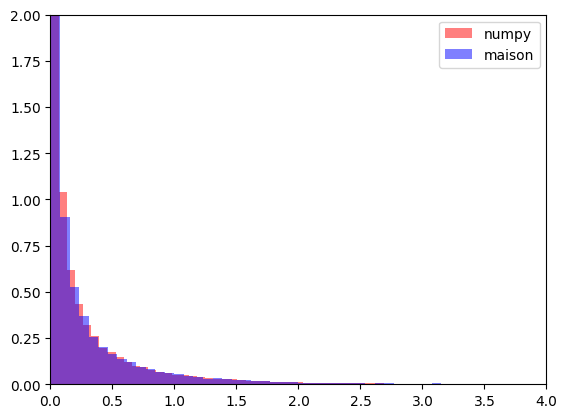

In [23]:
G4=np.random.gamma(shape=alpha,scale=1.0,size=N)
fig = plt.figure()
plt.hist(G4, density=True, bins=100, color="r", alpha=0.5, label="numpy")
plt.hist(G3, density=True, bins=100, color="b", alpha=0.5, label="maison")
plt.ylim(0,2)
plt.xlim(0,4)
plt.legend(loc="best")
plt.show()

## Méthode 2: égalité en loi + rejet

On utilise l'égalité en loi 
$$\frac{Y}{X} \overset{\mathcal L}{=} G\sim \Gamma(a,1),$$
où le couple $(X,Y)$ est distribué uniformément sur 
$$ D_a = \left\{(x,y)\in \mathbb{R}_{>0}^2 : 0< x < \sqrt{f\left(\frac{y}{x}\right)}\right\},$$
où
$$f(z)=z^{a-1}e^{-x}1_{z>0}.$$

On vérifie d'abord la borne de la question 2.


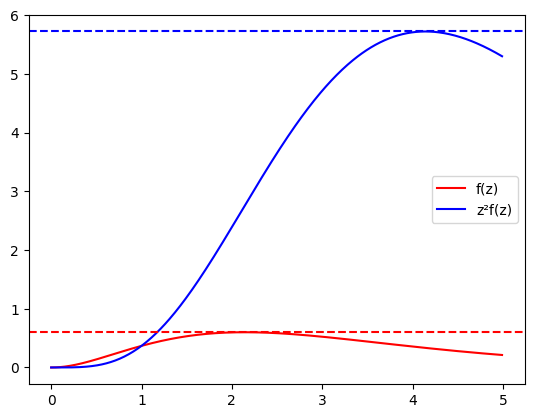

In [24]:
fx = x**(a-1)*np.exp(-x)
fig = plt.figure()
plt.plot(x,fx,label="f(z)",color="r")
plt.plot(x,x**2*fx,label="z²f(z)",color="b")

plt.axhline(((a-1)/np.e)**(a-1),linestyle="dashed",color="r")
plt.axhline(((a+1)/np.e)**(a+1),linestyle="dashed",color="b")
plt.legend(loc="best")
plt.show()

On peut alors simuler $(X,Y)$ uniforme sur $D_a$ par la méthode de rejet, par rapport à la densité uniforme sur 
$$]0,x_a[\times ]0,y_a[,$$
avec $x_a= \left(\frac{a-1}{e}\right)^{\frac{a-1}2}$, et $y_a=\left(\frac{a+1}{e}\right)^{\frac{a+1}2}$.

In [25]:
x_a = ((a-1)/np.e)**((a-1)/2)
y_a = ((a+1)/np.e)**((a+1)/2)

Ux = x_a * np.random.uniform(size=N)
Uy = y_a * np.random.uniform(size=N)

sqrt_f_ratio = np.sqrt((Uy/Ux)**(a-1)*np.exp(-Uy/Ux)) #
X = Ux[Ux < sqrt_f_ratio]
Y = Uy[Ux < sqrt_f_ratio]

k = x_a * y_a /(gamma(a)/2)
print("k theorique = ",k," k empirique = ",N/X.size)

k theorique =  1.6194599730822583  k empirique =  1.6246425786327008


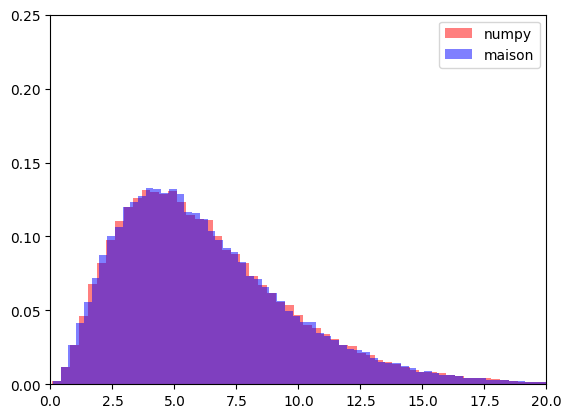

In [26]:
G1=np.random.gamma(shape=a,scale=1/theta,size=N)
G2=(Y/X)/theta

fig = plt.figure()
plt.hist(G1, density=True, bins=100, color="r", alpha=0.5, label="numpy")
plt.hist(G2, density=True, bins=100, color="b", alpha=0.5, label="maison")
plt.ylim(0,0.25)
plt.xlim(0,20)
plt.legend(loc="best")
plt.show()
